This notebook is for training the network for CIFAR10 dataset using a network with determined binarization.

In [1]:
%env THEANO_FLAGS=floatX=float32, device=gpu3
import numpy as np
import theano
import theano.tensor as T 
import lasagne
from __future__ import print_function
import BC_layers
import BC_utils
from pylearn2.datasets.zca_dataset import ZCA_Dataset
from pylearn2.utils import serial
import timeit
import inspect
import time
import logging
from lasagne.layers import batch_norm

env: THEANO_FLAGS=floatX=float32, device=gpu3


Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)


The original implementation use a script for pre-processing. I also found preprocessing script [here](https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/papers/maxout/svhn_preprocessing.py), and it seems that it is from the codes for Maxout Network. So here in order to make sure I have the same preprocessing result, I use the same code in the link.

Moreover, the code for downloading and splitting the data is from [here](https://raw.githubusercontent.com/lisa-lab/pylearn2/master/pylearn2/scripts/datasets/download_svhn.sh), also in the pylearn2 library. Although we can also use the code in the previous homeworks, here I use that code for consistency of the overall training.

In [2]:
# make logging functions

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('experiment.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
logger.addHandler(ch)
logger.addHandler(fh)

Again, here I use the same code to load the data.

In [3]:
train_set_size = 45000
    
print('Loading CIFAR-10 dataset...')
    
preprocessor = serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/preprocessor.pkl")

train_set = ZCA_Dataset(
    preprocessed_dataset=serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/train.pkl"), 
    preprocessor = preprocessor,
    start=0, stop = train_set_size)

valid_set = ZCA_Dataset(
    preprocessed_dataset= serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/train.pkl"), 
    preprocessor = preprocessor,
    start=45000, stop = 50000)  
    
test_set = ZCA_Dataset(
    preprocessed_dataset= serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/test.pkl"), 
    preprocessor = preprocessor)
        
# bc01 format
train_set.X = train_set.X.reshape(-1,3,32,32)
valid_set.X = valid_set.X.reshape(-1,3,32,32)
test_set.X = test_set.X.reshape(-1,3,32,32)
    
# flatten targets
train_set.y = np.hstack(train_set.y)
valid_set.y = np.hstack(valid_set.y)
test_set.y = np.hstack(test_set.y)

# for hinge loss 
# make targets onehot
def make_onehot(dataset, category=10):
    n_dataset = np.zeros((dataset.shape[0], category), dtype=np.int32)
    n_dataset[np.arange(n_dataset.shape[0]), dataset] = 1
    return n_dataset

train_set.y = np.subtract(np.multiply(2,make_onehot(train_set.y)),1).astype('int32')
valid_set.y = np.subtract(np.multiply(2,make_onehot(valid_set.y)),1).astype('int32')
test_set.y = np.subtract(np.multiply(2,make_onehot(test_set.y)),1).astype('int32')

Loading CIFAR-10 dataset...


In [4]:
# make dataset shared variables
from theano import shared
train_set_x = shared(train_set.X, borrow=True)
train_set_y = shared(train_set.y, borrow=True)
valid_set_x = shared(valid_set.X, borrow=True)
valid_set_y = shared(valid_set.y, borrow=True)
test_set_x = shared(test_set.X, borrow=True)
test_set_y = shared(test_set.y, borrow=True)

In [5]:
def make_network(input_shape, net_arch, net_spec):
    assert len(net_arch) == len(net_spec)
    
    layer = lasagne.layers.InputLayer(shape=input_shape)
    
    layers = {'in': layer}

    for i in range(len(net_arch)):
        if net_arch[i]=='noise':
            lasagne.layers.GaussianNoiseLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='dropout':
            layer = lasagne.layers.DropoutLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='reshape':
            layer = lasagne.layers.ReshapeLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='cnn':
            layer = BC_layers.Conv2DLayer(layer, **net_spec[i])
        
        elif net_arch[i]=='bn':
            layer = batch_norm(layer, **net_spec[i])
            
        elif net_arch[i]=='maxpool':
            layer = lasagne.layers.MaxPool2DLayer(layer, **net_spec[i])
            
        elif net_arch[i][:11]=='feedforward':
            if net_arch[i]=='feedforward_tanh':
                nonlinearity = lasagne.nonlinearities.tanh
            elif net_arch[i]=='feedforward_sigmoid':
                nonlinearity = lasagne.nonlinearities.sigmoid
            elif net_arch[i]=='feedforward_softmax':
                nonlinearity = lasagne.nonlinearities.softmax
            elif net_arch[i]=='feedforward_linear':
                nonlinearity = lasagne.nonlinearities.linear
            elif net_arch[i]=='feedforward_rectify':
                nonlinearity = lasagne.nonlinearities.rectify
            elif net_arch[i]=='feedforward_leaky':
                nonlinearity = lasagne.nonlinearities.leaky_rectify
            elif net_arch[i]=='feedforward_identity':
                nonlinearity = lasagne.nonlinearities.identity
                
            layer = BC_layers.DenseLayer(layer,nonlinearity=nonlinearity,**net_spec[i])
                
                
    layers['out'] = layer
    return layers

In [6]:
binary = True
stochastic = False
batch_size = 50
learning_rate = 3e-3
n_epoch = 250


net_arch=['cnn','bn','cnn','maxpool','bn','cnn','bn','cnn','maxpool','bn','cnn','bn','cnn','maxpool','bn',
         'feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 'feedforward_identity', 'bn']

net_spec=[{'binary':binary,'stochastic':stochastic,'num_filters':64,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 1'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':64,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 2'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':128,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 3'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':128,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 4'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':256,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 5'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':256,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 6'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
          {'name': 'batch norm 7'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
          {'name': 'batch norm 8'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':10}, 
          {'name': 'batch norm 9'}]

input_shape=(None, 3, 32, 32)
Layer = make_network(input_shape,net_arch,net_spec)

input = T.tensor4('input')
Y = T.imatrix('Y')
LR = T.fscalar('learning_rate')
    
# cost function
# hinge loss
cost_tr = T.mean(T.sqr(T.maximum(0.,1. - Y * \
                                        lasagne.layers.get_output(Layer['out'], 
                                                                  {Layer['in']: input}, deterministic=False))))
# compute update
update = BC_utils.calculate_update(Layer, cost_tr, LR, method='adam', binary=binary)
    
# other functions
cost_cv = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                       {Layer['in']: input}, deterministic=True))))
error_model = T.mean(T.neq(T.argmax(lasagne.layers.get_output(Layer['out'],
                                                              {Layer['in']: input}, deterministic=True), axis=1), 
                           T.argmax(Y, axis=1)), dtype='float32')
    
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches //= batch_size
n_valid_batches //= batch_size
n_test_batches //= batch_size


index = T.lscalar()
start_time = time.time()

logger.info('Computing function for training...')
train_model = theano.function(
    inputs=[index, LR],
    outputs=cost_tr,
    updates=update,
    givens={
        input: train_set_x[index * batch_size: (index + 1) * batch_size],
        Y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

print('Time spent: ', time.time() - start_time)

logger.info('Compiling cost function for testing...')
test_model = theano.function(
    inputs=[index],
    outputs=error_model,
    givens={
        input: test_set_x[index * batch_size:(index + 1) * batch_size],
        Y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)
print('Time spent: ', time.time() - start_time)

logger.info('Compiling cost function for validation...')
validate_model = theano.function(
    inputs=[index],
    outputs=error_model,
    givens={
        input: valid_set_x[index * batch_size:(index + 1) * batch_size],
        Y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)
print('Time spent: ', time.time() - start_time)

INFO:root:Computing function for training...
Computing function for training...
INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


Time spent:  9.75780296326
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 10.9075021744
Time spent:  12.5194621086


In [7]:
if True:    
    def train_nn(train_model, validate_model, test_model, LR, 
                n_train_batches, n_valid_batches, n_test_batches, n_epochs,
                verbose = True):
        """
        Function from HW3

        """

        # early-stopping parameters
        patience = 1e9  # look as this many examples regardless
        patience_increase = 15  # wait this much longer when a new best is
                               # found
        improvement_threshold = 0.99998  # a relative improvement of this much is
                                       # considered significant

        best_validation_loss = np.inf
        best_iter = 0
        test_score = 0.
        start_time = timeit.default_timer()

        epoch = 0
        best_epoch=0

        LR_decay = (2e-6/LR)**(1./n_epochs)

        tr_cost = []
        cv_error = []

        while epoch < n_epochs:
            epoch = epoch + 1
            start_epoch_time = time.time()
            
            LR = np.float32(LR)

            cur_tr_cost=0.

            for minibatch_index in range(n_train_batches):
                cur_tr_cost += train_model(minibatch_index, LR)

            tr_cost.append(cur_tr_cost)

            validation_losses = [validate_model(i) for i
                                         in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            cv_error.append(this_validation_loss)

            if verbose:
                logger.info("Epoch {} took {} seconds, tr cost {}, validation error {}%.\n".format(
                epoch, time.time() - start_epoch_time, cur_tr_cost, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_epoch = epoch

                # test it on the test set
                test_losses = [
                            test_model(i)
                            for i in range(n_test_batches)
                    ]
                test_score = np.mean(test_losses)

                if verbose:
                    print(('     epoch %i, test error of '
                                   'best model %f %%') %
                                  (epoch, 
                                   test_score * 100.))

            # decay learning rate
            LR *= LR_decay


        end_time = timeit.default_timer()

        # Print out summary
        print('Optimization complete.')
        print('Best validation score of %f %% obtained at epoch %i, '
              'with test performance %f %%' %
              (best_validation_loss * 100., best_epoch, test_score * 100.))

        return tr_cost, cv_error

In [8]:
# train the network

# deterministic binary
print('Determined binarization training...')
tr_cost_det_bi, cv_error_det_bi = train_nn(train_model, validate_model, test_model, learning_rate, 
                n_train_batches, n_valid_batches, n_test_batches, n_epoch,
                verbose = True)
print ('Training finished.\n')

INFO:root:Epoch 1 took 169.502606869 seconds, tr cost 380.832576263, validation error 36.9200050831%.

Epoch 1 took 169.502606869 seconds, tr cost 380.832576263, validation error 36.9200050831%.



Determined binarization training...
     epoch 1, test error of best model 38.230002 %

INFO:root:Epoch 2 took 170.175004005 seconds, tr cost 179.878657637, validation error 29.4799983501%.

Epoch 2 took 170.175004005 seconds, tr cost 179.878657637, validation error 29.4799983501%.




     epoch 2, test error of best model 30.730000 %

INFO:root:Epoch 3 took 170.418281078 seconds, tr cost 148.140731262, validation error 27.0399987698%.

Epoch 3 took 170.418281078 seconds, tr cost 148.140731262, validation error 27.0399987698%.




     epoch 3, test error of best model 28.590000 %

INFO:root:Epoch 4 took 169.87351799 seconds, tr cost 124.562252249, validation error 23.8000005484%.

Epoch 4 took 169.87351799 seconds, tr cost 124.562252249, validation error 23.8000005484%.




     epoch 4, test error of best model 24.980000 %

INFO:root:Epoch 5 took 169.845341921 seconds, tr cost 105.083876233, validation error 23.5400021076%.

Epoch 5 took 169.845341921 seconds, tr cost 105.083876233, validation error 23.5400021076%.




     epoch 5, test error of best model 23.909999 %

INFO:root:Epoch 6 took 169.861443043 seconds, tr cost 85.8188821115, validation error 23.1399998069%.

Epoch 6 took 169.861443043 seconds, tr cost 85.8188821115, validation error 23.1399998069%.




     epoch 6, test error of best model 23.180000 %

INFO:root:Epoch 7 took 170.037318945 seconds, tr cost 68.7696433103, validation error 22.9200005531%.

Epoch 7 took 170.037318945 seconds, tr cost 68.7696433103, validation error 22.9200005531%.




     epoch 7, test error of best model 23.549999 %

INFO:root:Epoch 8 took 169.885348797 seconds, tr cost 54.5772326902, validation error 22.5000023842%.

Epoch 8 took 169.885348797 seconds, tr cost 54.5772326902, validation error 22.5000023842%.




     epoch 8, test error of best model 23.250000 %

INFO:root:Epoch 9 took 169.854239225 seconds, tr cost 43.2494715868, validation error 22.2000002861%.

Epoch 9 took 169.854239225 seconds, tr cost 43.2494715868, validation error 22.2000002861%.




     epoch 9, test error of best model 22.610001 %

INFO:root:Epoch 10 took 169.950833082 seconds, tr cost 36.0282824493, validation error 21.8000009656%.

Epoch 10 took 169.950833082 seconds, tr cost 36.0282824493, validation error 21.8000009656%.




     epoch 10, test error of best model 21.790001 %

INFO:root:Epoch 11 took 169.986255169 seconds, tr cost 29.1273870836, validation error 21.4400008321%.

Epoch 11 took 169.986255169 seconds, tr cost 29.1273870836, validation error 21.4400008321%.




     epoch 11, test error of best model 22.150001 %

INFO:root:Epoch 12 took 169.646398067 seconds, tr cost 24.9676932021, validation error 21.0600018501%.

Epoch 12 took 169.646398067 seconds, tr cost 24.9676932021, validation error 21.0600018501%.




     epoch 12, test error of best model 22.760002 %

INFO:root:Epoch 13 took 169.700863123 seconds, tr cost 21.6437125841, validation error 21.0400015116%.

Epoch 13 took 169.700863123 seconds, tr cost 21.6437125841, validation error 21.0400015116%.




     epoch 13, test error of best model 21.980000 %

INFO:root:Epoch 14 took 169.669955969 seconds, tr cost 18.5174108038, validation error 20.1399996877%.

Epoch 14 took 169.669955969 seconds, tr cost 18.5174108038, validation error 20.1399996877%.




     epoch 14, test error of best model 21.350001 %

INFO:root:Epoch 15 took 169.796665907 seconds, tr cost 16.2255005967, validation error 20.5399990082%.

Epoch 15 took 169.796665907 seconds, tr cost 16.2255005967, validation error 20.5399990082%.

INFO:root:Epoch 16 took 169.830788136 seconds, tr cost 14.7778600928, validation error 20.5999985337%.

Epoch 16 took 169.830788136 seconds, tr cost 14.7778600928, validation error 20.5999985337%.

INFO:root:Epoch 17 took 169.830887079 seconds, tr cost 12.5529239599, validation error 20.37999928%.

Epoch 17 took 169.830887079 seconds, tr cost 12.5529239599, validation error 20.37999928%.

INFO:root:Epoch 18 took 169.775048018 seconds, tr cost 11.4051924096, validation error 20.0200006366%.

Epoch 18 took 169.775048018 seconds, tr cost 11.4051924096, validation error 20.0200006366%.




     epoch 18, test error of best model 20.760000 %

INFO:root:Epoch 19 took 169.707120895 seconds, tr cost 10.6231308687, validation error 19.4600015879%.

Epoch 19 took 169.707120895 seconds, tr cost 10.6231308687, validation error 19.4600015879%.




     epoch 19, test error of best model 20.630001 %

INFO:root:Epoch 20 took 169.770219088 seconds, tr cost 9.37312796169, validation error 19.6600019932%.

Epoch 20 took 169.770219088 seconds, tr cost 9.37312796169, validation error 19.6600019932%.

INFO:root:Epoch 21 took 169.73845005 seconds, tr cost 8.37556369161, validation error 19.540001452%.

Epoch 21 took 169.73845005 seconds, tr cost 8.37556369161, validation error 19.540001452%.

INFO:root:Epoch 22 took 169.770596981 seconds, tr cost 7.84837663233, validation error 19.4999977946%.

Epoch 22 took 169.770596981 seconds, tr cost 7.84837663233, validation error 19.4999977946%.

INFO:root:Epoch 23 took 169.828885078 seconds, tr cost 7.08508417528, validation error 18.8799992204%.

Epoch 23 took 169.828885078 seconds, tr cost 7.08508417528, validation error 18.8799992204%.




     epoch 23, test error of best model 20.010000 %

INFO:root:Epoch 24 took 169.786890984 seconds, tr cost 6.85541661668, validation error 18.9999997616%.

Epoch 24 took 169.786890984 seconds, tr cost 6.85541661668, validation error 18.9999997616%.

INFO:root:Epoch 25 took 169.95648098 seconds, tr cost 5.26290599678, validation error 18.6599999666%.

Epoch 25 took 169.95648098 seconds, tr cost 5.26290599678, validation error 18.6599999666%.




     epoch 25, test error of best model 19.470002 %

INFO:root:Epoch 26 took 169.738835812 seconds, tr cost 5.28822878493, validation error 19.6600005031%.

Epoch 26 took 169.738835812 seconds, tr cost 5.28822878493, validation error 19.6600005031%.

INFO:root:Epoch 27 took 169.882878065 seconds, tr cost 5.15566785224, validation error 18.9599990845%.

Epoch 27 took 169.882878065 seconds, tr cost 5.15566785224, validation error 18.9599990845%.

INFO:root:Epoch 28 took 170.990586042 seconds, tr cost 4.68020482392, validation error 18.2000026107%.

Epoch 28 took 170.990586042 seconds, tr cost 4.68020482392, validation error 18.2000026107%.




     epoch 28, test error of best model 19.860001 %

INFO:root:Epoch 29 took 171.83069396 seconds, tr cost 4.25736249396, validation error 19.0600007772%.

Epoch 29 took 171.83069396 seconds, tr cost 4.25736249396, validation error 19.0600007772%.

INFO:root:Epoch 30 took 172.076003075 seconds, tr cost 3.73729111897, validation error 18.2800024748%.

Epoch 30 took 172.076003075 seconds, tr cost 3.73729111897, validation error 18.2800024748%.

INFO:root:Epoch 31 took 172.177458048 seconds, tr cost 3.98925492482, validation error 18.6600014567%.

Epoch 31 took 172.177458048 seconds, tr cost 3.98925492482, validation error 18.6600014567%.

INFO:root:Epoch 32 took 172.076604843 seconds, tr cost 3.11679706563, validation error 18.1199982762%.

Epoch 32 took 172.076604843 seconds, tr cost 3.11679706563, validation error 18.1199982762%.




     epoch 32, test error of best model 19.060001 %

INFO:root:Epoch 33 took 172.041175127 seconds, tr cost 2.55364466461, validation error 18.0000022054%.

Epoch 33 took 172.041175127 seconds, tr cost 2.55364466461, validation error 18.0000022054%.




     epoch 33, test error of best model 18.900001 %

INFO:root:Epoch 34 took 171.657648802 seconds, tr cost 2.89579428177, validation error 18.440002203%.

Epoch 34 took 171.657648802 seconds, tr cost 2.89579428177, validation error 18.440002203%.

INFO:root:Epoch 35 took 171.499719143 seconds, tr cost 2.90177602704, validation error 18.2000041008%.

Epoch 35 took 171.499719143 seconds, tr cost 2.90177602704, validation error 18.2000041008%.

INFO:root:Epoch 36 took 172.220247984 seconds, tr cost 2.36263089471, validation error 17.3800006509%.

Epoch 36 took 172.220247984 seconds, tr cost 2.36263089471, validation error 17.3800006509%.




     epoch 36, test error of best model 18.880001 %

INFO:root:Epoch 37 took 172.347787857 seconds, tr cost 2.42569135637, validation error 18.3800011873%.

Epoch 37 took 172.347787857 seconds, tr cost 2.42569135637, validation error 18.3800011873%.

INFO:root:Epoch 38 took 171.524044037 seconds, tr cost 2.01747774734, validation error 17.4799978733%.

Epoch 38 took 171.524044037 seconds, tr cost 2.01747774734, validation error 17.4799978733%.

INFO:root:Epoch 39 took 170.950973034 seconds, tr cost 1.79473422974, validation error 17.1400010586%.

Epoch 39 took 170.950973034 seconds, tr cost 1.79473422974, validation error 17.1400010586%.




     epoch 39, test error of best model 18.790001 %

INFO:root:Epoch 40 took 171.427069902 seconds, tr cost 1.64758088532, validation error 18.3200016618%.

Epoch 40 took 171.427069902 seconds, tr cost 1.64758088532, validation error 18.3200016618%.

INFO:root:Epoch 41 took 171.804708958 seconds, tr cost 1.74753017114, validation error 17.9400011897%.

Epoch 41 took 171.804708958 seconds, tr cost 1.74753017114, validation error 17.9400011897%.

INFO:root:Epoch 42 took 171.112791061 seconds, tr cost 1.34368911919, validation error 18.2000011206%.

Epoch 42 took 171.112791061 seconds, tr cost 1.34368911919, validation error 18.2000011206%.

INFO:root:Epoch 43 took 171.524991989 seconds, tr cost 1.55565371394, validation error 17.9800018668%.

Epoch 43 took 171.524991989 seconds, tr cost 1.55565371394, validation error 17.9800018668%.

INFO:root:Epoch 44 took 170.669811964 seconds, tr cost 1.31745153519, validation error 17.919999361%.

Epoch 44 took 170.669811964 seconds, tr cost 1.31745153519, validation error 17.919999361%.

INFO:root:Ep


     epoch 68, test error of best model 17.819999 %

INFO:root:Epoch 69 took 172.244719028 seconds, tr cost 0.155651088729, validation error 17.3600003123%.

Epoch 69 took 172.244719028 seconds, tr cost 0.155651088729, validation error 17.3600003123%.

INFO:root:Epoch 70 took 171.442085028 seconds, tr cost 0.179404984811, validation error 17.159999907%.

Epoch 70 took 171.442085028 seconds, tr cost 0.179404984811, validation error 17.159999907%.

INFO:root:Epoch 71 took 171.018345118 seconds, tr cost 0.202520905862, validation error 17.2199994326%.

Epoch 71 took 171.018345118 seconds, tr cost 0.202520905862, validation error 17.2199994326%.

INFO:root:Epoch 72 took 170.664819002 seconds, tr cost 0.260044794516, validation error 17.3799991608%.

Epoch 72 took 170.664819002 seconds, tr cost 0.260044794516, validation error 17.3799991608%.

INFO:root:Epoch 73 took 170.730316162 seconds, tr cost 0.137139425237, validation error 17.6200002432%.

Epoch 73 took 170.730316162 seconds, tr cost 0.137139425237, validation error 17.6200002432%.

IN


     epoch 77, test error of best model 18.060002 %

INFO:root:Epoch 78 took 170.490291119 seconds, tr cost 0.0855740781667, validation error 17.499999702%.

Epoch 78 took 170.490291119 seconds, tr cost 0.0855740781667, validation error 17.499999702%.

INFO:root:Epoch 79 took 171.33228302 seconds, tr cost 0.0940595738392, validation error 17.0599997044%.

Epoch 79 took 171.33228302 seconds, tr cost 0.0940595738392, validation error 17.0599997044%.

INFO:root:Epoch 80 took 171.416424036 seconds, tr cost 0.0920783838533, validation error 17.0000001788%.

Epoch 80 took 171.416424036 seconds, tr cost 0.0920783838533, validation error 17.0000001788%.

INFO:root:Epoch 81 took 171.089297056 seconds, tr cost 0.11936757611, validation error 17.3999994993%.

Epoch 81 took 171.089297056 seconds, tr cost 0.11936757611, validation error 17.3999994993%.

INFO:root:Epoch 82 took 171.373864889 seconds, tr cost 0.0930161938996, validation error 17.080001533%.

Epoch 82 took 171.373864889 seconds, tr cost 0.0930161938996, validation error 17.080001533%.




     epoch 91, test error of best model 18.020001 %

INFO:root:Epoch 92 took 171.545511961 seconds, tr cost 0.0380499683834, validation error 16.8400004506%.

Epoch 92 took 171.545511961 seconds, tr cost 0.0380499683834, validation error 16.8400004506%.




     epoch 92, test error of best model 17.729999 %

INFO:root:Epoch 93 took 171.93748498 seconds, tr cost 0.0412405512533, validation error 16.9599995017%.

Epoch 93 took 171.93748498 seconds, tr cost 0.0412405512533, validation error 16.9599995017%.

INFO:root:Epoch 94 took 171.552883863 seconds, tr cost 0.0580815972534, validation error 17.159999907%.

Epoch 94 took 171.552883863 seconds, tr cost 0.0580815972534, validation error 17.159999907%.

INFO:root:Epoch 95 took 172.046068907 seconds, tr cost 0.0312639048765, validation error 17.1000003815%.

Epoch 95 took 172.046068907 seconds, tr cost 0.0312639048765, validation error 17.1000003815%.

INFO:root:Epoch 96 took 171.337964058 seconds, tr cost 0.0182024822836, validation error 16.7200013995%.

Epoch 96 took 171.337964058 seconds, tr cost 0.0182024822836, validation error 16.7200013995%.




     epoch 96, test error of best model 17.889999 %

INFO:root:Epoch 97 took 171.447058916 seconds, tr cost 0.03265820009, validation error 16.8999999762%.

Epoch 97 took 171.447058916 seconds, tr cost 0.03265820009, validation error 16.8999999762%.

INFO:root:Epoch 98 took 171.044075012 seconds, tr cost 0.0316557298851, validation error 17.2600001097%.

Epoch 98 took 171.044075012 seconds, tr cost 0.0316557298851, validation error 17.2600001097%.

INFO:root:Epoch 99 took 170.506093025 seconds, tr cost 0.0341886598422, validation error 17.2399997711%.

Epoch 99 took 170.506093025 seconds, tr cost 0.0341886598422, validation error 17.2399997711%.

INFO:root:Epoch 100 took 170.436558008 seconds, tr cost 0.0268681482847, validation error 16.9199988246%.

Epoch 100 took 170.436558008 seconds, tr cost 0.0268681482847, validation error 16.9199988246%.

INFO:root:Epoch 101 took 170.439939022 seconds, tr cost 0.0163814190831, validation error 17.0599997044%.

Epoch 101 took 170.439939022 seconds, tr cost 0.0163814190831, validation error 17.0599


     epoch 130, test error of best model 17.569999 %

INFO:root:Epoch 131 took 173.475084066 seconds, tr cost 0.00194257076594, validation error 17.0399993658%.

Epoch 131 took 173.475084066 seconds, tr cost 0.00194257076594, validation error 17.0399993658%.

INFO:root:Epoch 132 took 173.605958939 seconds, tr cost 0.00279703457394, validation error 17.0199990273%.

Epoch 132 took 173.605958939 seconds, tr cost 0.00279703457394, validation error 17.0199990273%.

INFO:root:Epoch 133 took 172.957221985 seconds, tr cost 0.00683222978951, validation error 17.12000072%.

Epoch 133 took 172.957221985 seconds, tr cost 0.00683222978951, validation error 17.12000072%.

INFO:root:Epoch 134 took 172.650877953 seconds, tr cost 0.00270516250599, validation error 16.9599995017%.

Epoch 134 took 172.650877953 seconds, tr cost 0.00270516250599, validation error 16.9599995017%.

INFO:root:Epoch 135 took 173.469930887 seconds, tr cost 0.00192888285181, validation error 17.0400008559%.

Epoch 135 took 173.469930887 seconds, tr cost 0.00192888285181, validati


Optimization complete.
Best validation score of 16.579998 % obtained at epoch 130, with test performance 17.569999 %
Training finished.



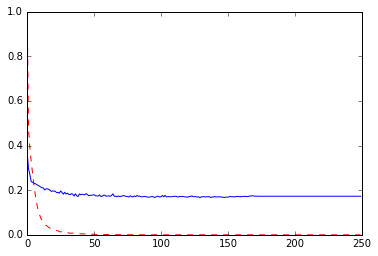

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(tr_cost_det_bi / max(tr_cost_det_bi),'r--')
plt.plot(cv_error_det_bi,'b')
plt.show()

In [10]:
# save to .npz
np.save('det_binary', [tr_cost_det_bi, cv_error_det_bi])